# MIS 583 Assignment 3: Flower Classfication

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm 戴嘉萱, M084030006

## Flower Classification

Image classification is a core and fundamental task in computer vision.

In the assignment, you will implement a multi-class image classifier to recognize flowers.

You will design and train a deep convolutional network from scratch to predict the class label of a flower image. This will help you gain experience with network design and get more familiar with PyTorch.

**Please note that you’re not allowed to use a pre-trained model.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa) to join the competition.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.6.0`

In [ ]:
!python --version
!pip freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

This dataset contains 4323 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes: 
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Get Data

請先到共用雲端硬碟將檔案`flower_data.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1rTfeCpKXoQXI978QiTWC-AI1vwGvd5SU/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Unzip Data

解壓縮 `flower_data.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train`的圖片3112張，`val`的圖片778章，`test`的圖片433張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [3]:
!unzip -qq ./drive/My\ Drive/flower_data.zip

## Loading the dataset


### Custom dataset

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [4]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['file_path'])
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):

        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))

        return data, label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

Pytorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/docs/stable/torchvision/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

(**Slide.07 page.49**)

In [5]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train =transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.RandomCrop((224, 224)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=(-90, 90)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test =transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [6]:
dataset_train = FlowerData('./data/train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('./data/val.csv', mode='val', transform=transforms_test)
dataset_test = FlowerData('./data/test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")


The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 3112 images in dataset_train.



### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [8]:
import torch.nn as nn 
import torch.nn.functional as F

class Your_CNN_Model(nn.Module): 
	def __init__(self): 
		super().__init__()
		########################################################################
		#     TODO: use nn.xxx method to generate a CNN model part             #
		########################################################################

		#input=3*224*224 #3為chanel，代表rgb
		x=32
		y=64
		self.conv = nn.Sequential(
			nn.Conv2d(3, x, 5, padding=2),# in,out,k
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(x, y, 5, stride=1, padding=2),
			nn.BatchNorm2d(y),
			nn.ReLU(),
			nn.MaxPool2d(2, stride=2),

			nn.Conv2d(y,128, 5, stride=1, padding=2),
			nn.BatchNorm2d(128),
			nn.ReLU(),
			nn.MaxPool2d(2, stride=2),

			nn.Conv2d(128,256, 5, stride=1, padding=2),
			nn.BatchNorm2d(256),
			nn.ReLU(),
			nn.MaxPool2d(2, stride=2),

			nn.Conv2d(256,512, 5, stride=1, padding=2),
			nn.BatchNorm2d(512),
			nn.ReLU(),
			nn.MaxPool2d(2, stride=2),

			nn.ReLU(),
			)
		self.fc_model = nn.Sequential(
			
		  nn.Linear(512*7*7,500),#查看summary
			nn.BatchNorm1d(500),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(500, 500),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(500,5))#5為輸出幾類
 # You can change the variable name
		########################################################################
		#                           End of your code                           #
		########################################################################

	def forward(self, x): 
		if not isinstance(x, torch.Tensor):
			x = torch.Tensor(x)
		########################################################################
		#     TODO: forward your model and get output                          #
		########################################################################
		
		x = self.conv(x)
		x = x.view(x.size(0), -1)
		out = self.fc_model(x) 
		########################################################################
		#                           End of your code                           #
		########################################################################
		return out

In [9]:
model = Your_CNN_Model()
model = model.cuda()
print(model)
from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

Your_CNN_Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [10]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion =nn.CrossEntropyLoss()#多種類別
optimizer =optim.SGD(model.parameters(),lr=0.01,momentum=0.9,nesterov=False)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.cuda()

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [11]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for i, data in enumerate(input_data, 0):
        images, labels = data[0].cuda(), data[1].cuda()
        
        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        out=model(images)
        loss =criterion(out,labels)
        loss.backward()
        optimizer.step()

        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted =torch.max(out.data,1)#分類會自動套運softmax
        total_count +=len(labels)
        acc_count += (predicted==labels).sum().item()
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [12]:
#train(train_loader, model, criterion, optimizer)

def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            images, labels = data[0].cuda(), data[1].cuda()

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            
            out=model(images)
            loss =criterion(out,labels)
            _, predicted =torch.max(out.data,1)
            total_count += len(labels)
            acc_count += (predicted==labels).sum().item()
            loss_list.append(loss.item())

            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

## **Early stopping**

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [15]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs =200
log_interval = 2 # print acc and loss in per log_interval time
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
early_stopping = EarlyStopping(patience=20, verbose=True)

for epoch in range(1, max_epochs + 1):

    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
    
    early_stopping(val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Validation loss decreased (inf --> 1.343504).  Saving model ...
==================== Epoch 2 ====================
Train Acc: 0.570373 Train Loss: 1.058445
Val Acc: 0.551414   Val Loss: 1.276456
Validation loss decreased (1.343504 --> 1.276456).  Saving model ...
Validation loss decreased (1.276456 --> 1.132669).  Saving model ...
==================== Epoch 4 ====================
Train Acc: 0.645244 Train Loss: 0.923558
Val Acc: 0.604113   Val Loss: 1.112213
Validation loss decreased (1.132669 --> 1.112213).  Saving model ...
EarlyStopping counter: 1 out of 20
==================== Epoch 6 ====================
Train Acc: 0.673522 Train Loss: 0.854375
Val Acc: 0.652956   Val Loss: 0.976341
Validation loss decreased (1.112213 --> 0.976341).  Saving model ...
EarlyStopping counter: 1 out of 20
==================== Epoch 8 ====================
Train Acc: 0.681877 Train Loss: 0.804412
Val Acc: 0.664524   Val Loss: 0.981250
EarlyStopping counter: 2 out of 20
Validation loss decreased (0.976341

<All keys matched successfully>

#### Visualize accuracy and loss

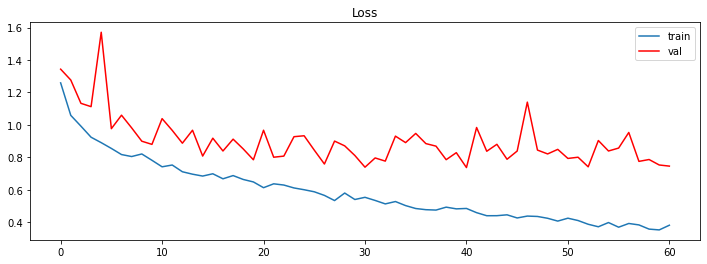

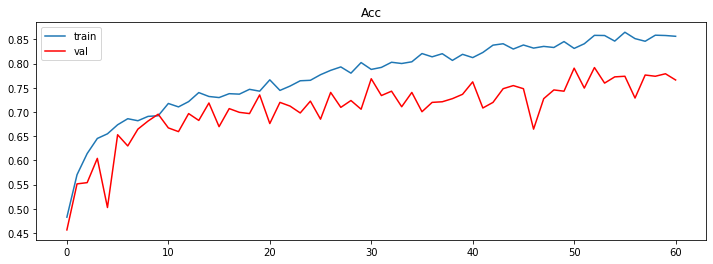

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()



### Predict Result

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [17]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [18]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['Id', 'Category'])
    writer.writeheader()
    for result in output_csv:
        idx+=1
        writer.writerow({'Id':idx, 'Category':result})

In [2]:
[1,3,4]


[1, 3, 4]

In [8]:
# import csv
# idx=0
# with open( r'C:\Users\戴嘉萱\Documents\深度學習作業\作業4-衣服類別辨識\result.csv', 'w', newline='') as csvFile:
#     writer = csv.DictWriter(csvFile, fieldnames=['Id', 'Category'])
#     writer.writeheader()
#     for result in [1,3,4]:
#         idx+=1
#         writer.writerow({'Id':idx, 'Category':result})

# Keep trying and write report

持續調整模型、訓練方法、損失函數、優化器等，來訓練出更好的模型，並記錄使用不同參數得出的效果，以利後續 Report 的撰寫。

大家加油！